# PROACT Dataset

In [4]:
import config as cfg
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from utility.survival import make_time_bins
from SurvivalEVAL.Evaluations.util import KaplanMeier

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'large',
                     'axes.titlesize': 'large',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

from utility.plot import load_tf_color
TFColor = load_tf_color()

df = pd.read_csv(Path.joinpath(cfg.PROACT_DATA_DIR, 'proact_processed_idea3.csv'), index_col=0)
event_names = ["Communication", "Movement", "Swallowing", "Breathing"]
for event_name in event_names:
    df = df.loc[(df[f'TTE_{event_name}'] > 0) & (df[f'TTE_{event_name}'] <= 365)] # 0 - 500
df = df.dropna(subset='Handgrip_Strength') # drop rows with no handgrip test
df['El_escorial'] = df['El_escorial'].replace('Possible', 'Probable') # Replace "Possible" with "Probable"
df = df.drop('Race_Caucasian', axis=1) # Drop race information
df = df.drop('El_escorial', axis=1) # Drop el_escorial
df = df.drop(['Height', 'Weight'], axis=1) # drop height/weight
df = df.drop(columns=['ABDUCTOR_POLLICIS_BREVIS_Strength', 
                      'SHOULDER_Strength', 
                      'FIRST_DORSAL_INTEROSSEOUS_OF_THE_HAND_Strength'], axis=1) # drop rare strength tests

In [5]:
# Print event distribution
for event_col in event_names:
    obs_arr = np.array(df[f"Event_{event_col}"])
    n_censored = obs_arr.shape[0] - obs_arr.sum()
    print(f"Number of samples: {len(df)}")
    print(f"Number of censored/uncensored: {n_censored}/{obs_arr.shape[0]-n_censored}")
    print(f"{round(n_censored / obs_arr.shape[0] * 100, 2)}% of records are censored\n")

Number of samples: 742
Number of censored/uncensored: 559/183
75.34% of records are censored

Number of samples: 742
Number of censored/uncensored: 555/187
74.8% of records are censored

Number of samples: 742
Number of censored/uncensored: 630/112
84.91% of records are censored

Number of samples: 742
Number of censored/uncensored: 627/115
84.5% of records are censored



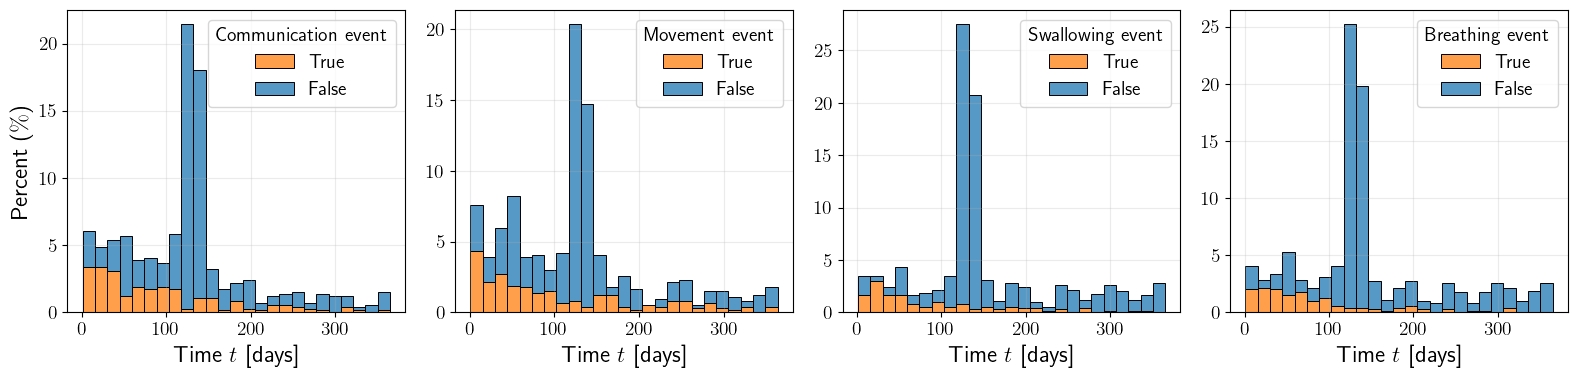

In [6]:
# Plot event distribution
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
axs = axs.flatten()
for i, col in enumerate(event_names):
    event = df[[f'TTE_{col}', f'Event_{col}']]
    sns.histplot(x=f'TTE_{col}', data=event, hue=f'Event_{col}',
                 multiple="stack", bins=25, ax=axs[i], stat="percent")
    axs[i].set_xlabel("Time $t$ [days]")
    if i == 0:
        axs[i].set_ylabel("Percent ($\%$)")
    else:
        axs[i].set_ylabel("")
    axs[i].grid(True, alpha=0.25)
    #axs[i].set_xticks([0, 100, 200, 300, 400])
    axs[i].legend(title=event_names[i] + " event", loc='upper right', labels=["True", "False"])
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/proact_event_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [4]:
# Plot KM curves ["Communication", "Movement", "Swallowing", "Breathing"]
event_times = df[['TTE_Communication', 'TTE_Movement', 'TTE_Swallowing', 'TTE_Breathing']].to_numpy()
event_indicators = df[['Event_Communication', 'Event_Movement', 'Event_Swallowing', 'Event_Breathing']].to_numpy()

time_bins = make_time_bins(event_times, event=None)
time_bins = torch.cat((torch.tensor([0]), time_bins))

# Initialize subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for event_id in range(4): # 4 events
    times = event_times[:, event_id]
    indicators = event_indicators[:, event_id]
    
    km_model = KaplanMeier(times, indicators)
    km_surv_prob = torch.from_numpy(km_model.predict(time_bins)).numpy()
    
    # Plotting the survival curve
    axes[event_id].step(time_bins.numpy(), km_surv_prob, where='post',
                        label=r"$\mathbb{E}[S(t)]$" + f" {event_names[event_id]}", color=TFColor[3])
    axes[event_id].set_xlabel("Time $t$ [days]")
    if event_id % 2 == 0:
        axes[event_id].set_ylabel("Survival Probability")
    axes[event_id].set_ylim(0, 1)
    axes[event_id].legend(loc='lower left') 
    axes[event_id].grid(True, alpha=0.25)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/proact_km_curves.pdf", format='pdf', bbox_inches='tight')
plt.show()

KeyError: "['TTE_Communication', 'TTE_Movement', 'TTE_Breathing'] not in index"